In [465]:
import pandas as pd
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials 
# from matplotlib.ticker import AutoMinorLocator 
from scipy.signal import correlate
from statsmodels.tsa.stattools import adfuller, pacf, acf
from scipy.stats import shapiro, probplot, norm # shapiro wilk test for normality sample size thousands or fewer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from scipy.stats import shapiro, probplot, norm # shapiro wilk test for normality sample size thousands or fewer
import random
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from sklearn.linear_model import LinearRegression

# -----> AXIS TITLES <-----

# Load data

In [466]:
def get_yahoo_data(start_date, end_date, ticker):
    extended_date = datetime.strptime(end_date,'%Y-%m-%d')+timedelta(days=20)
    extended_date = extended_date.strftime('%Y-%m-%d')
    ticker_data = YahooFinancials(ticker).get_historical_price_data(start_date, extended_date, 'daily')
    prices = pd.DataFrame(ticker_data[ticker]['prices'])
    prices['formatted_date'] = pd.to_datetime(prices['formatted_date'])
    prices.set_index('formatted_date', inplace=True)
    prices = prices.drop(columns='date')
    prices['1d returns'] = prices['close'].pct_change().shift(-1)
    prices['2d returns'] = prices['close'].pct_change(periods=2).shift(-2)
    prices['3d returns'] = prices['close'].pct_change(periods=3).shift(-3)
    prices['5d returns'] = prices['close'].pct_change(periods=5).shift(-5)
    prices['10d returns'] = prices['close'].pct_change(periods=10).shift(-10)
    prices['Symbol'] = ticker
    prices = prices[prices.index <= end_date]
    return prices

In [672]:
AAPL = get_yahoo_data('2018-01-01', '2019-12-31', 'AAPL') # try with 2020-09-30
AAPL.index.names = ['Date']
AAPL.head()
len(AAPL) 

503

# Stationarity and Normality

The null hypothesis of the Augmented Dickey-Fuller (ADF) is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

## simple differencing


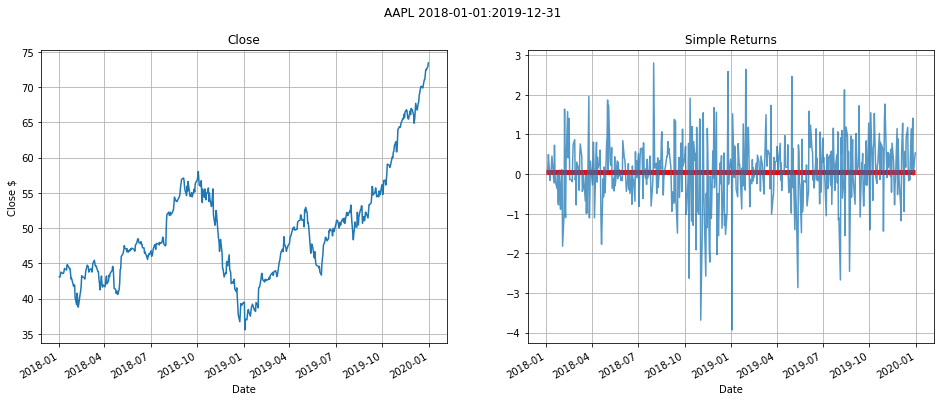

In [675]:
# initial look at the data 

fig, axis = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('AAPL 2018-01-01:2019-12-31')

AAPL['close'].plot(ax = axis[0])
# axis[0].set_xlabel('Date')
axis[0].set_ylabel('Close $')
axis[0].grid()
axis[0].title.set_text('Close')

AAPL['close'].diff(1).dropna().plot(ax=axis[1], alpha=0.75)
axis[1].hlines(y=AAPL['close'].diff(1).dropna().mean(), xmin='2018-01-01', xmax='2019-12-31', color='r', linewidth=5 )
# axis[1].set_xlabel('Date')
axis[1].set_ylabel('')
axis[1].grid()
axis[1].title.set_text('Simple Returns')


In [676]:
adf_results = adfuller(AAPL['close'].diff(1).dropna())
p = adf_results[0]
critical_vals = adf_results[-2]
for key, value in critical_vals.items():
    if p < value:
        print(f'stationary with {key} significance')

stationary with 1% significance
stationary with 5% significance
stationary with 10% significance


In [677]:
shapiro_pval = shapiro(AAPL['close'].diff(1).dropna())[1]
for alpha in [0.1,0.05,0.01]:
    if shapiro_pval < alpha:
        print(f'Normal at {int(alpha*100)}% significance')

Normal at 10% significance
Normal at 5% significance
Normal at 1% significance


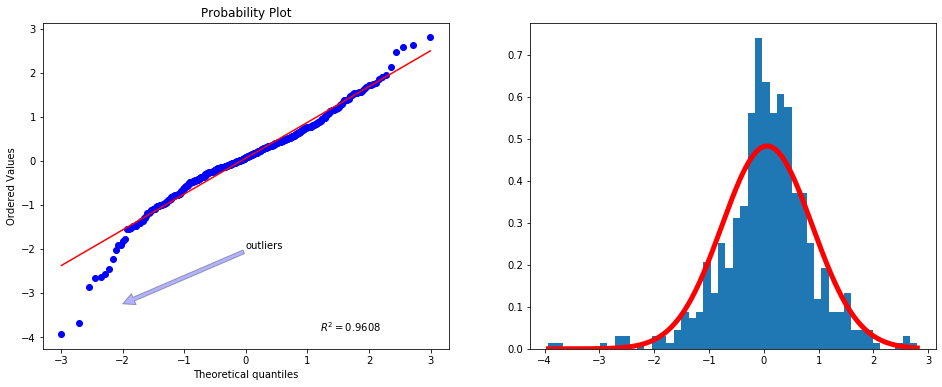

In [678]:
# first difference: mean at 2.16% of max, 
# AAPL['close'].diff(1).dropna().mean()/max(AAPL['close'].diff(1).dropna())
# significant outliers and long tail on left

first_diff = AAPL['close'].diff(1).dropna()

fig, axis = plt.subplots(1,2, figsize=(16,6))
QQ_object= probplot(first_diff, plot=axis[0], rvalue=True)
# r_squared = QQ_object[-1][-1]
# axis.text(-3,2.5,f'$r^2=${round(r_squared,2)}')
axis[0].annotate('outliers', xy=(-2, -3.25), xytext=(0, -2),
            arrowprops=dict(facecolor='blue', shrink=0.001, alpha=0.3))

x = np.linspace(min(first_diff), max(first_diff), len(first_diff))
m , s = norm.fit(first_diff)
axis[1].plot(x, norm.pdf(x,m,s), color='r', linewidth=5)
axis[1].hist(first_diff, bins=50, density=True)
_ = 0

In [679]:
# second difference: mean at 0.2% of max, 
# AAPL['close'].diff(1).diff(1).dropna().mean()/max(AAPL['close'].diff(1).diff(1).dropna())
# long tail on right, acceptable 

# second_diff = AAPL['close'].diff(1).diff(1).dropna()

# fig, axis = plt.subplots(1,2,figsize=(16,6))

# QQ_object= probplot(second_diff, plot=axis[0], rvalue=True)

# axis[0].annotate('outlier', xy=(2.8, 5.5), xytext=(0, 4),
#             arrowprops=dict(facecolor='blue', shrink=0.001, alpha=0.3))

# x = np.linspace(min(second_diff), max(second_diff), len(second_diff))
# m , s = norm.fit(second_diff)
# axis[1].plot(x, norm.pdf(x,m,s), color='r', linewidth=5)
# axis[1].hist(second_diff, bins=50, density=True)
# _ = 0

## Box-Cox (optional)

In [680]:
print("No transform QQ correlation:",round(probplot(AAPL['close'], rvalue=True)[-1][-1],3) )
for lambd in range(-5,6):
    if lambd != 0:
        transform = AAPL['close']**lambd
    else:
        transform = np.log(AAPL['close'])
    print(f"lambda={lambd} QQ correlation",round(probplot(transform, rvalue=True)[-1][-1],3))

No transform QQ correlation: 0.97
lambda=-5 QQ correlation 0.956
lambda=-4 QQ correlation 0.975
lambda=-3 QQ correlation 0.988
lambda=-2 QQ correlation 0.995
lambda=-1 QQ correlation 0.995
lambda=0 QQ correlation 0.987
lambda=1 QQ correlation 0.97
lambda=2 QQ correlation 0.945
lambda=3 QQ correlation 0.914
lambda=4 QQ correlation 0.879
lambda=5 QQ correlation 0.841


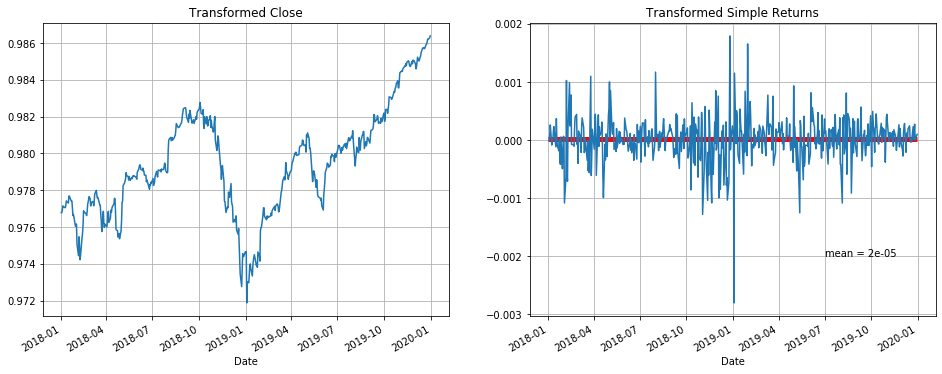

In [682]:
AAPL['Lambda=-1'] = ((AAPL['close']**-1)-1)/(-1)
lambda_diff1 = AAPL['Lambda=-1'].diff(1).dropna()

fig, axis = plt.subplots(1,2, figsize=(16,6))
AAPL['Lambda=-1'].plot(ax=axis[0])
# axis[0].set_xlabel('Date')
axis[0].title.set_text('Transformed Close')
axis[0].grid()

lambda_diff1.plot(ax=axis[1])
# axis[1].set_xlabel('Date')
axis[1].title.set_text('Transformed Simple Returns')
axis[1].hlines(y=lambda_diff1.mean(), xmin='2018-01-01', xmax='2019-12-31', color='r', linewidth=5 )
axis[1].text('2019-07-01',-0.002,f"mean = {round(lambda_diff1.mean(),5)}")
axis[1].grid()

In [683]:
adf_results = adfuller(lambda_diff1)
p = adf_results[0]
critical_vals = adf_results[-2]
for key, value in critical_vals.items():
    if p < value:
        print(f'stationary with {key} significance')

stationary with 1% significance
stationary with 5% significance
stationary with 10% significance


In [684]:
shapiro_pval = shapiro(lambda_diff1)[1]
for alpha in [0.1,0.05,0.01]:
    if shapiro_pval < alpha:
        print(f'Normal at {int(alpha*100)}% significance')

Normal at 10% significance
Normal at 5% significance
Normal at 1% significance


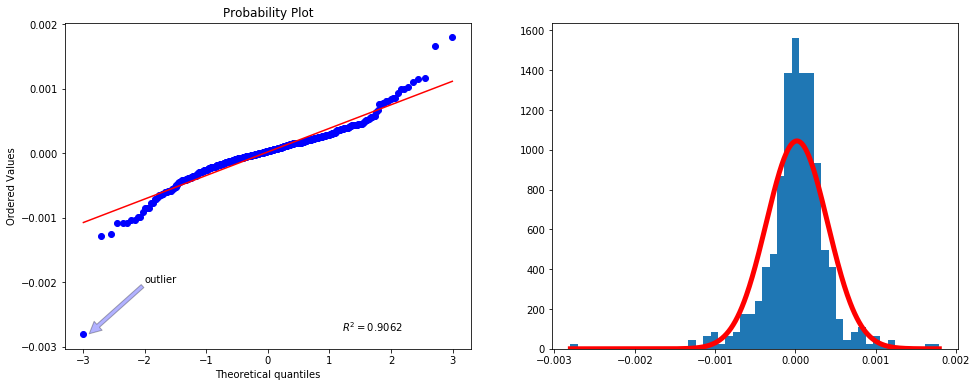

In [685]:
# transformed first difference: mean at 1.06% of max, 
# transformed_first_diff.mean()/max(transformed_first_diff)
# long tail on left, breakpoint, outlier


fig, axis = plt.subplots(1,2,figsize=(16,6))

QQ_object = probplot(lambda_diff1, plot= axis[0], rvalue=True)
axis[0].annotate('outlier', xy=(-2.9,-0.0028), xytext=(-2, -0.002),
            arrowprops=dict(facecolor='blue', shrink=0.001, alpha=0.3))

x = np.linspace(min(lambda_diff1), max(lambda_diff1), len(lambda_diff1))
m , s = norm.fit(lambda_diff1)
axis[1].plot(x, norm.pdf(x,m,s), color='r', linewidth=5)
axis[1].hist(lambda_diff1, bins=50, density=True)

_=0

# Series Autocorrelation Predictability
ACF plot is merely a bar chart of the coefficients of correlation between a time series and lags of itself. <br>
In general, the "partial" correlation between two variables is the amount of correlation between them which is not explained by their mutual correlations with a specified set of other variables. For example, if we are regressing a variable Y on other variables X1, X2, and X3, the partial correlation between Y and X3 is the amount of correlation between Y and X3 that is not explained by their common correlations with X1 and X2. This partial correlation can be computed as the square root of the reduction in variance that is achieved by adding X3 to the regression of Y on X1 and X2.

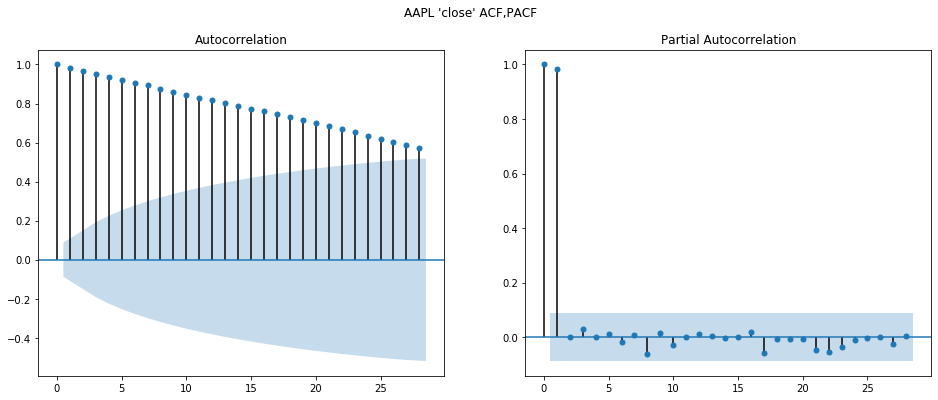

In [686]:
fig, axis = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("AAPL 'close' ACF,PACF")
plot_acf(AAPL['close'] , ax=axis[0])
plot_pacf(AAPL['close'], ax=axis[1])
_=0

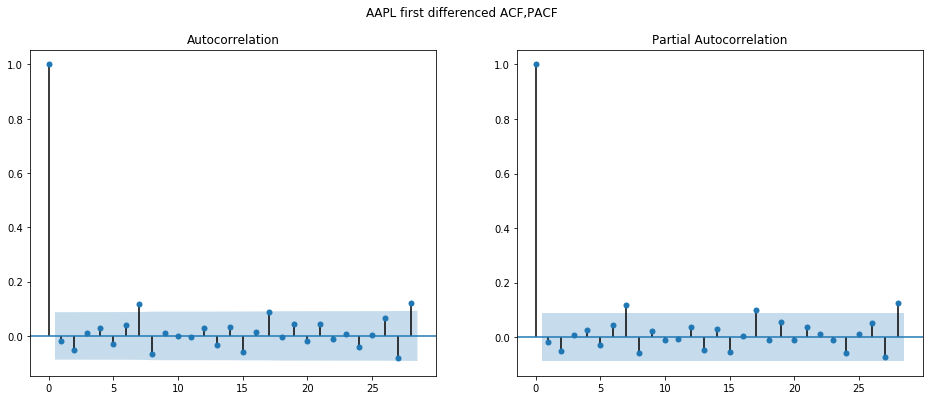

In [687]:
# first difference seems to be sufficient 
fig, axis = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("AAPL first differenced ACF,PACF")
plot_acf(lambda_diff1 , ax=axis[0])
plot_pacf(lambda_diff1, ax=axis[1])
_=0

## Breakpoint 
Since we have chosen and ARIMA with p,q=1,1 we have a multivariate model following $$y_t = c + \sum_{j=1}^q\theta_t\epsilon_{t-j} + \sum_{i=1}^p\phi_iy_{t-i}$$
which makes this a multivariate regression. <br>


In [688]:
# remove outlier(s)
# mean at 0
# normal with high kurtosis

# outlier_index = lambda_diff1[lambda_diff1 == lambda_diff1.min()].index
# transformed_differenced = AAPL['Lambda=-1'].drop(outlier_index).diff(1).dropna()

# fig, ax = plt.subplots(2,2, figsize=(16,10))
# fig.tight_layout(pad=7)

# AAPL['Lambda=-1'].drop(outlier_index).plot(ax=ax[0,0])
# ax[0,0].grid()

# transformed_differenced.plot(ax=ax[0,1], alpha=0.75)
# ax[0,1].hlines(transformed_differenced.mean(), xmin='2018-01-01', xmax='2019-12-31', color='r', linewidth=5)
# ax[0,1].text('2019-07-01',-0.0015,f"mean = {round(transformed_differenced.mean(),5)}")
# ax[0,1].grid()

# # fit normal distribution to dataAAPL['Lambda=-1'].drop(outlier_index).diff(1).dropna()
# x = np.linspace(min(transformed_differenced), max(transformed_differenced), len(transformed_differenced))
# m , s = norm.fit(transformed_differenced)
# ax[1,0].plot(x, norm.pdf(x,m,s), color='r', linewidth=5)
# ax[1,0].hist(transformed_differenced, bins=50, density=True)


# QQ_object = probplot(transformed_differenced, plot=ax[1,1], rvalue=True)


In [689]:
# adf_results = adfuller(transformed_differenced)
# p = adf_results[0]
# critical_vals = adf_results[-2]
# for key, value in critical_vals.items():
#     if p < value:
#         print(f'stationary with {key} significance')

In [690]:
# shapiro_pval = shapiro(transformed_differenced)[1]
# for alpha in [0.1,0.05,0.01]:
#     if shapiro_pval < alpha:
#         print(f'Normal at {int(alpha*100)}% significance')

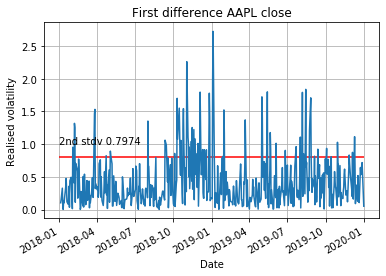

In [691]:
rw2_resids = ((AAPL['close'].diff(1).dropna().rolling(2).mean() - AAPL['close'].diff(1).dropna())**2)**0.5
ffig, axis = plt.subplots()
(rw2_resids).plot(ax=axis)
axis.hlines(2*rw2_resids.std(), xmin='2018-01-01', xmax='2019-12-31', color='r')
axis.text('2018-01',1,f'2nd stdv {round(2*rw2_resids.std(),4)}')
axis.set(ylabel='Realised volatility', title='First difference AAPL close')
axis.grid()

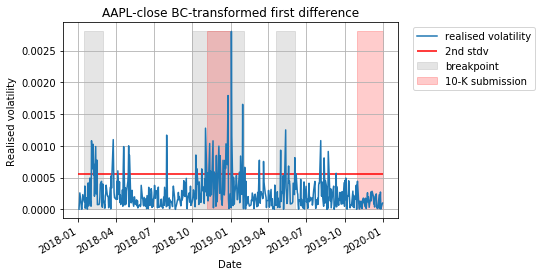

In [713]:
fig, axis = plt.subplots()
((lambda_diff1**2)**0.5).plot(ax=axis, label="realised volatility")
axis.hlines(((lambda_diff1**2)**0.5).std()*2,xmin='2018-01-01', xmax='2019-12-31', color='r', label='2nd stdv')
# axis.text('2019-10',0.00075, f'2nd stdv {round(((lambda_diff1**2)**0.5).std()*2,4)}')
axis.grid()
axis.set(ylabel='Realised volatility', title='AAPL-close BC-transformed first difference')


shading_height = ((lambda_diff1**2)**0.5).max() 

bp1 = pd.date_range('2018-01-15','2018-03-01')
xs = [shading_height for _ in range(len(bp1))]
axis.fill_between(bp1, xs, alpha=0.2, color='grey', label='breakpoint')

# bp2 = pd.date_range('2018-04-15','2018-05-15')
# xs = [shading_height for _ in range(len(bp2))]
# axis.fill_between(bp2, xs, alpha=0.2, color='grey')

bp3 = pd.date_range('2018-10-01','2019-02-01')
xs = [shading_height for _ in range(len(bp3))]
axis.fill_between(bp3, xs, alpha=0.2, color='grey')

bp4 = pd.date_range('2019-04-20','2019-06-05')
xs = [shading_height for _ in range(len(bp4))]
axis.fill_between(bp4, xs, alpha=0.2, color='grey')

# bp5 = pd.date_range('2019-08-01','2019-09-01')
# xs = [shading_height for _ in range(len(bp5))]
# axis.fill_between(bp5, xs, alpha=0.2, color='grey')

tenK_submission = pd.date_range('2018-11-05','2019-01-01')
xs = [shading_height for _ in range(len(tenK_submission))]
axis.fill_between(tenK_submission, xs, alpha=0.2, color='red')

tenK_submission = pd.date_range('2019-10-31','2019-12-31')
xs = [shading_height for _ in range(len(tenK_submission))]
axis.fill_between(tenK_submission, xs, alpha=0.2, color='red', label='10-K submission')

axis.legend(bbox_to_anchor=(1.425, 1))

# significance level ~ 5% with 2 std encapsulation in the model
# looking at the residuals, the breakpoints are frequent occurrence of 3sigma events
# Q1&4-2018 and Q1-2019

# ##########################################
# PLOT BARS OF SENTIMENT WORDS ON THIS CHART
############################################

In [610]:
# fig, axis = plt.subplots()
# (transformed_differenced**2).plot(ax=axis)
# axis.grid()
# axis.title.set_text('Squared returns')
# axis.set_ylabel('Realised volatility')
# axis.set_xlabel('Date')

95.2

# $SARIMA(p,d,q)(P,D,Q)_m$ model

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.
- m: depends on the frequency of the data (4 for quarterly, 12 for monthly and 365 for daily).

In [892]:
train = AAPL['close'].loc[:'2019-10-30']
test = AAPL['close'].loc['2019-10-30':]

In [893]:
# train.index = pd.DatetimeIndex(train.index.values,freq="D")
# test.index = pd.DatetimeIndex(test.index.values,freq="D")
#freq missing non-work days, add and ffill
train_dates = pd.date_range(train.index.min(), train.index.max(), freq='D')
train = train.reindex(train_dates)
train.ffill(inplace=True)

test_dates = pd.date_range(test.index.min(), test.index.max(), freq='D')
test = test.reindex(test_dates)
test.ffill(inplace=True)

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


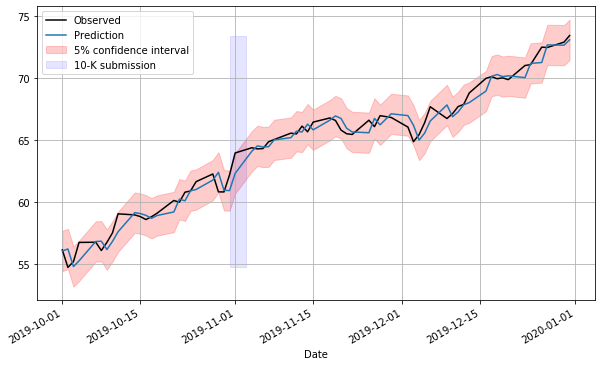

In [963]:
# mod = SARIMAX(train, order=(1,1,1), seasonal_order=(0,0,0,0))
mod = SARIMAX(AAPL['close'], order=(1,2,1), seasonal_order=(0,0,0,0))

fit_res = mod.fit()

graph_start = '2019-10'
graph_end = '2019-12-31'

horizon = len(AAPL.loc[train.index[-1]:test.index[-1],'close'])
predict = fit_res.get_prediction(start=train.index[0], end='2019-12-31')

################
forecast = fit_res.get_prediction(end='2019-11-15') # (test.index[-1] - train.index[-1]).days 
##############

predict_ci = predict.conf_int().iloc[2:].loc[graph_start:graph_end]
forecast_ci = forecast.conf_int().iloc[2:].loc[graph_start:graph_end]

fig, ax = plt.subplots(figsize=(10,6))

AAPL['close'].loc[graph_start:graph_end].plot(ax=ax, label='Observed', color='k')
predict.predicted_mean.loc[graph_start:graph_end].plot(ax=ax, label='Prediction')
# forecast.predicted_mean.loc[graph_start:].plot(ax=ax, label='Forecast')
# ax.plot(AAPL.loc[train.index[-1]:test.index[-1],'close'].index, forecast.predicted_mean.values)


ax.fill_between(predict_ci.index, predict_ci.iloc[:,0], predict_ci.iloc[:,1], color='r', alpha=0.2, label='5% confidence interval')
# ax.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='r', alpha=0.2)

shading_maxheight = AAPL['close'].loc[graph_start:graph_end].max()
shading_minheight = AAPL['close'].loc[graph_start:graph_end].min()
tenK_submission = pd.date_range('2019-10-31','2019-11-03')
x_max = [shading_maxheight for _ in range(len(tenK_submission))]
x_min = [shading_minheight for _ in range(len(tenK_submission))]
ax.fill_between(tenK_submission, x_max, x_min, alpha=0.1, color='blue', label='10-K submission')

ax.grid()
ax.legend(loc='upper left')